<a href="https://colab.research.google.com/github/elizachistova/Jupyter-Notebooks---DS/blob/main/sentiment_analysis/ProjetDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DS Sentiment Analysis**

We have a CSV file containing information about
- the reviews given by customers on the products they buy on Amazon
- the ratings they have given.

We want develop a solution for predicting whether a review is positive or negative. The result of this task is useful, for example, for classifying future reviews for which there will be no associated feelings.

The project is divided into the following parts:

[1.   General information and data preparation](#1)

[2.   Model Training](#2)

[3.   Summary](#3)

[4.   Spark Exercise](#4)



<a name="1"></a>
# 1. General information and data preparation

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
from nltk.tokenize import word_tokenize
import re
from pymystem3 import Mystem
import nltk as nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve,roc_auc_score,precision_recall_curve
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import time
import timeit
from wordcloud import WordCloud

We load our file and explore the data:

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/pr_10k.csv'

In [ ]:
df = pd.read_csv(file_path,sep=';')

In [ ]:
df.head()

,name,review,sentiment
0,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,positive
1,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,positive
2,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,positive
3,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",positive
4,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",positive


We have three columns in our data:

(i) Name: the name of the product purchased;

(ii) Review: the opinion of a customer who has purchased the product in question in text form;

(iii) Sentiment: a sentiment field indicating whether the opinion is "positive" or "negative".

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       9996 non-null   object
 1   review     9976 non-null   object
 2   sentiment  9999 non-null   object
dtypes: object(3)
memory usage: 234.5+ KB


In [ ]:
df.describe()

,name,review,sentiment
count,9996,9976,9999
unique,709,9976,2
top,Leachco Snoogle Total Body Pillow,Very soft and comfortable and warmer than it l...,positive
freq,366,1,7886


We can see that we have only two sentiment (Positive; negative) and we have only 709 unique products reviewed.

In [ ]:
df.isna().sum().sort_values(ascending=False)

review       23
name          3
sentiment     0
dtype: int64

In [ ]:
df[df['name'].isnull()]

,name,review,sentiment
9649,NaN,"If you're searching for an elegant, inexpensiv...",positive
9650,NaN,This item looks very good and I was going to o...,negative
9651,NaN,Bought this item for my child's crib but found...,negative


In [ ]:
df[df['review'].isnull()]

,name,review,sentiment
32,SoftPlay Twinkle Twinkle Elmo A Bedtime Book,NaN,positive
51,Our Baby Girl Memory Book,NaN,positive
650,"Summer Infant, Ultimate Training Pad - Twin Ma...",NaN,positive
949,Safety 1st Deluxe 4-in-1 Bath Station,NaN,negative
1069,Northstate Superyard Playgate Light Gray,NaN,positive
1250,Munchkin Mozart Magic Cube,NaN,positive
1552,"Graco TotBloc Pack 'N Play with Carry Bag, Bug...",NaN,positive
1553,"Graco TotBloc Pack 'N Play with Carry Bag, Bug...",NaN,positive
2175,Prince Lionheart Table Edge Guard with 4 Corne...,NaN,negative
2210,BABYBJORN Toilet Trainer - White/Red,NaN,positive


As there is very little amount of missing data compared to overall size, we can just delete it:

In [ ]:
df = df.drop(df[df['name'].isnull()].index)
df = df.drop(df[df['review'].isnull()].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9973 entries, 0 to 9998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       9973 non-null   object
 1   review     9973 non-null   object
 2   sentiment  9973 non-null   object
dtypes: object(3)
memory usage: 311.7+ KB


In [ ]:
df['sentiment'].value_counts()

sentiment
positive    7868
negative    2105
Name: count, dtype: int64

In [ ]:
df['sentiment'].value_counts(normalize=True)*100

sentiment
positive    78.893011
negative    21.106989
Name: proportion, dtype: float64

The data is not very balanced, as negative sentiment analysis accounts for ca. 21% only. We need to consider this in training of our models. We transform the sentiment into numerical values (1; 0):



In [ ]:
df['sentiment_num'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,name,review,sentiment,sentiment_num
0,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,positive,1
1,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,positive,1
2,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,positive,1
3,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",positive,1
4,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",positive,1


Now we look at our features: we could use Review column or both product and review. Preprocessing involves the following steps:

*   Lowercasting
*   Removing special characters
*   Tokenization (splitting text into tokens)
*   Removing Stop Words
*   Lemmatization

I have decided to try to see if we want to include products name into our features (combining product name and review). In general I think it's not needed, as we would like to create a general sentiment model that can be applied across various products without being biased by specific product names, but we will compare. We create a combined column:

In [ ]:
df['combined'] = df['name'] + " " + df['review']

We perform all preprocessing on both columns.

We transform text to unicode strings just in case (even though it's english text, but there might be some encoding issues, other characters)

In [ ]:
corpus = df['review'].values.astype('U')
corpus = df['combined'].values.astype('U')

Then we would like to remove special characters

In [ ]:
def clear_text(text):
    return " ".join(re.sub(r'[^A-Za-z]', ' ',text).split())

In [ ]:
print("Original text example", corpus[9])

Original text example Baby Tracker&reg, - Daily Childcare Journal, Schedule Log This book is perfect!  I'm a first time new mom, and this book made it so easy to keep track of feedings, diaper changes, sleep.  Definitely would recommend this for new moms.  Plus it's small enough that I throw in the diaper back for doctor visits.


In [ ]:
print("Changed text example", clear_text(corpus[9]))

Changed text example Baby Tracker reg Daily Childcare Journal Schedule Log This book is perfect I m a first time new mom and this book made it so easy to keep track of feedings diaper changes sleep Definitely would recommend this for new moms Plus it s small enough that I throw in the diaper back for doctor visits


In [ ]:
df['clean_review'] = df['review'].apply(clear_text)
df['combined'] = df['combined'].apply(clear_text)
df.head()

,name,review,sentiment,sentiment_num,combined,clean_review
0,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,positive,1,Annas Dream Full Quilt with Shams Very soft an...,Very soft and comfortable and warmer than it l...
1,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,positive,1,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase I ha...
2,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,positive,1,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non stop when I trie...
3,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",positive,1,Stop Pacifier Sucking without tears with Thumb...,When the Binky Fairy came to our house we didn...
4,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",positive,1,A Tale of Baby s Days with Peter Rabbit Lovely...,Lovely book it s bound tightly so you may not ...


Next we use Natural Language Toolkit to remove stopwords.

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
print(stopwords)

{'if', 'wouldn', 'y', "didn't", 'it', 'because', 'been', 'll', 'will', 'yourselves', 'had', 'who', 'o', 'in', 'haven', 'under', 'once', 'shan', 'about', 'an', "that'll", 'the', "you're", 'very', 'needn', 'after', 'some', 'ma', 'that', 'where', 'below', 'didn', 'to', 'their', 'out', 'theirs', "mightn't", 'should', 'which', 'she', 'until', 'yours', 'ain', 'himself', 'myself', 'and', 'me', 'this', 'is', "it's", 'same', 'mustn', "won't", 'm', 'i', "she's", 'than', 'shouldn', "you've", 'from', 'they', "aren't", 'you', 'such', 'having', 'them', 'but', 'more', 'here', 'as', 'did', 'nor', "haven't", "shan't", 'those', 'own', 'there', 'we', 'at', 'ourselves', 'won', "doesn't", 'being', 'other', 're', 'why', 'any', 'most', 'up', 'over', 'only', 'itself', "mustn't", 'my', 'yourself', 'do', "couldn't", 'his', 'was', 'on', 'each', 'again', 'have', 'then', 'can', 'aren', 'hadn', 'off', 'isn', 've', 'wasn', 'few', 'just', 'further', 'when', "should've", 'mightn', 'your', 'our', 'herself', 'through', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def rem_en(input_txt):
    words = input_txt.lower().split()
    nf_words = [word for word in words if word not in stopwords]
    nf_text = " ".join(nf_words)
    return nf_text

In [ ]:
df["clean_review"] = df["clean_review"].apply(lambda s: rem_en(s))
df[["review","clean_review"]].head()

,review,clean_review
0,Very soft and comfortable and warmer than it l...,soft comfortable warmer looks fit full size be...
1,This is a product well worth the purchase. I ...,product well worth purchase found anything els...
2,All of my kids have cried non-stop when I trie...,kids cried non stop tried ween pacifier found ...
3,"When the Binky Fairy came to our house, we did...",binky fairy came house special gift book help ...
4,"Lovely book, it's bound tightly so you may not...",lovely book bound tightly may able add alot ph...


In [ ]:
df["combined"] = df["combined"].apply(lambda s: rem_en(s))

In [ ]:
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['clean_review'] = df.clean_review.apply(lemmatize_text)
df.head()

,name,review,sentiment,sentiment_num,combined,clean_review
0,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,positive,1,annas dream full quilt shams soft comfortable ...,"[soft, comfortable, warmer, look, fit, full, s..."
1,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,positive,1,stop pacifier sucking without tears thumbuddy ...,"[product, well, worth, purchase, found, anythi..."
2,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,positive,1,stop pacifier sucking without tears thumbuddy ...,"[kid, cried, non, stop, tried, ween, pacifier,..."
3,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",positive,1,stop pacifier sucking without tears thumbuddy ...,"[binky, fairy, came, house, special, gift, boo..."
4,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",positive,1,tale baby days peter rabbit lovely book bound ...,"[lovely, book, bound, tightly, may, able, add,..."


In [ ]:
df['combined'] = df.combined.apply(lemmatize_text)
df.head()

,name,review,sentiment,sentiment_num,combined,clean_review
0,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,positive,1,"[anna, dream, full, quilt, sham, soft, comfort...","[soft, comfortable, warmer, look, fit, full, s..."
1,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,positive,1,"[stop, pacifier, sucking, without, tear, thumb...","[product, well, worth, purchase, found, anythi..."
2,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,positive,1,"[stop, pacifier, sucking, without, tear, thumb...","[kid, cried, non, stop, tried, ween, pacifier,..."
3,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",positive,1,"[stop, pacifier, sucking, without, tear, thumb...","[binky, fairy, came, house, special, gift, boo..."
4,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",positive,1,"[tale, baby, day, peter, rabbit, lovely, book,...","[lovely, book, bound, tightly, may, able, add,..."


**Stemming** is the process of reducing words to their root form by removing suffixes, often using a set of heuristic rules
Over-stemming and under-stemming are two common errors. Over-stemming: when two semantically distinct words are reduced to the same root (for example, news to new); under-stemming is when two words semantically related are not reduced to the same root.

**Lemmatizing** produces valid words that are more semantically meaningful: the process reduces words to their base or dictionary form (lemma)
Even though lemmatizing is slower than stemming (here we do not have too much data), it provides better accuracy. SO we have decided to continue with lemmatizing.

We can do wordcloud out of interest:

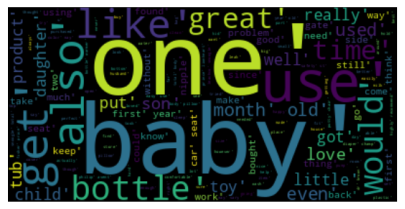

In [ ]:
all_r = ' '.join(df['combined'].astype(str))
wordcloud = WordCloud().generate(all_r)
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<a name="2"></a>
# 2. Model Training



We prepare some functions that will help us evaluate the models:

In [ ]:
#function with evaluation metrics
def bold(text):
      display(Markdown(f"**{text}**"))

def evaluate_model(df_classifier, train_target, train_features, test_features, test_target):
    bold("Model Evaluation")
    print("-"*50 + "\n")
    bold("Train Evaluation")
    print("Train Accuracy :", accuracy_score(train_target, df_classifier.predict(train_features)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(train_target, df_classifier.predict(train_features)))
    print("Train F1-Score:")
    print(f1_score(train_target, df_classifier.predict(train_features)))
    print("\n" + "-"*50 + "\n")
    bold("Test Evaluation")
    print("Test Accuracy :", accuracy_score(test_target, df_classifier.predict(test_features)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(test_target, df_classifier.predict(test_features)))
    print("Test F1-Score:")
    print(f1_score(test_target, df_classifier.predict(test_features)))
    print("\n" + "-"*50 + "\n")
    print("Classification Report:")
    print(classification_report(test_target, df_classifier.predict(test_features)))

In [ ]:
#fucntion for ROC curve
def curves(model, name, test_target, test_features):
    roc_auc = roc_auc_score(test_target, model.predict(test_features))
    fpr, tpr, thresholds = roc_curve(test_target, model.predict_proba(test_features)[:,1])
    precision, recall, thresholds = precision_recall_curve(test_target, model.predict_proba(test_features)[:, 1])
    plt.figure(figsize=(3, 3))
    plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.savefig('ROC')
    plt.show()
    plt.figure(figsize=(3, 3))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.show()

We would like to start with simpler models, and then look at more complex ones. We are going to look at the following models:


*   Naive Bayes Classification
*   Logistic Regression
*   Decision Trees
*   Random Forest
*   Support Vector Machines - SVM
*   Light Gradient Boosting Machine - LGBM




Now we will create an additional table to help us compare the models based on results:

In [ ]:
eval_table = {"models": ["Naive_Bayes","Log_Regression","DecisionTree","Random_Forest","SVM","LGBM"],"Accuracy": [0.0]*6, "ROC AUC": [0.0]*6,"time_model": [0.0]*6,"time_predict": [0.0]*6, "comment": " "*6}
eval_table=pd.DataFrame(eval_table)
print(eval_table)

           models  Accuracy  ROC AUC  time_model  time_predict comment
0     Naive_Bayes       0.0      0.0         0.0           0.0        
1  Log_Regression       0.0      0.0         0.0           0.0        
2    DecisionTree       0.0      0.0         0.0           0.0        
3   Random_Forest       0.0      0.0         0.0           0.0        
4             SVM       0.0      0.0         0.0           0.0        
5            LGBM       0.0      0.0         0.0           0.0        


We separate our data set into a training set and a test set:

In [ ]:
target=df['sentiment_num']
features=df['clean_review'].map(lambda x: list(map(str.lower, x)))
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=12345)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_target.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_target.shape)

Training Features Shape: (7479,)
Training Labels Shape: (7479,)
Testing Features Shape: (2494,)
Testing Labels Shape: (2494,)


We do the same for combined column as we want to test:

In [ ]:
target_comb=df['sentiment_num']
features_comb=df['combined'].map(lambda x: list(map(str.lower, x)))
train_features_comb, test_features_comb, train_target_comb, test_target_comb = train_test_split(features_comb, target_comb, test_size=0.25, random_state=12345)

We are going to calculate TF-IDF (The tf-idf is an statistic that increases with the number of times a word appears in the document, penalized by the number of documents in the corpus that contain the word)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=None)
train_features = vectorizer.fit_transform(train_features.apply(lambda x: ' '.join(x)))
test_features = vectorizer.transform(test_features.apply(lambda x: ' '.join(x)))

In [ ]:
train_features_comb = vectorizer.fit_transform(train_features_comb.apply(lambda x: ' '.join(x)))
test_features_comb = vectorizer.transform(test_features_comb.apply(lambda x: ' '.join(x)))

# a. Naive Bayes Classification


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.798235058162856
Train Confusion Matrix:
[[  57 1505]
 [   4 5913]]
Train F1-Score:
0.8868391451068615

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.785485164394547
Test Confusion Matrix:
[[   8  535]
 [   0 1951]]
Test F1-Score:
0.8794230335812486

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.03       543
           1       0.78      1.00      0.88      1951

    accuracy                           0.79      2494
   macro avg       0.89      0.51      0.45      2494
weighted avg       0.83      0.79      0.69      2494



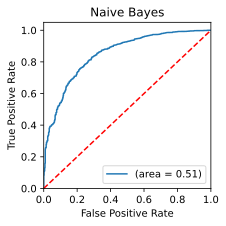

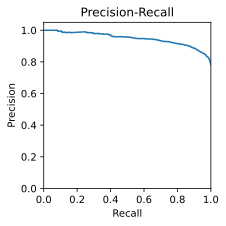

In [ ]:
start_NB = time.time()
NB = MultinomialNB()
NB.fit(train_features, train_target)
mid_NB = time.time()
target_pred = NB.predict(test_features)
end_NB = time.time()
evaluate_model(NB,train_target, train_features, test_features, test_target)
curves(NB,'Naive Bayes',test_target, test_features)

Recall for negative class is extermely low

We would like to check the performance on combined column:

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.7995721353122075
Train Confusion Matrix:
[[  66 1496]
 [   3 5914]]
Train F1-Score:
0.8875215727470549

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.7858861267040899
Test Confusion Matrix:
[[   9  534]
 [   0 1951]]
Test F1-Score:
0.8796212804328224

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       543
           1       0.79      1.00      0.88      1951

    accuracy                           0.79      2494
   macro avg       0.89      0.51      0.46      2494
weighted avg       0.83      0.79      0.70      2494



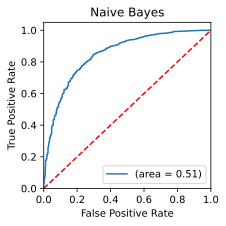

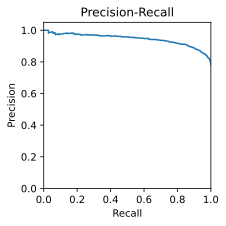

In [ ]:
start_NBC = time.time()
NBC = MultinomialNB()
NBC.fit(train_features_comb, train_target_comb)
mid_NBC = time.time()
target_pred = NBC.predict(test_features_comb)
end_NBC = time.time()
evaluate_model(NBC,train_target_comb, train_features_comb, test_features_comb, test_target_comb)
curves(NBC,'Naive Bayes',test_target_comb, test_features_comb)

We know that our classes are not very balanced: NearMiss is an under-sampling technique used to balance the dataset by reducing the number of majority class samples

In [ ]:
nm=NearMiss()
features_train_miss, target_train_miss= nm.fit_resample(train_features,train_target.ravel())

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.867797695262484
Train Confusion Matrix:
[[1229  333]
 [  80 1482]]
Train F1-Score:
0.8777021024578028

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.813953488372093
Test Confusion Matrix:
[[ 372  171]
 [ 293 1658]]
Test F1-Score:
0.8772486772486772

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       543
           1       0.91      0.85      0.88      1951

    accuracy                           0.81      2494
   macro avg       0.73      0.77      0.75      2494
weighted avg       0.83      0.81      0.82      2494



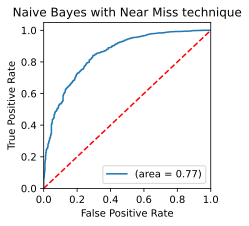

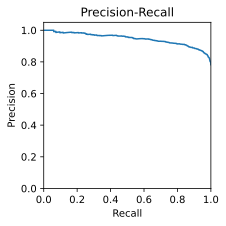

In [ ]:
start_NBNM = time.time()
NBNM = MultinomialNB()
NBNM.fit(features_train_miss, target_train_miss)
mid_NBNM = time.time()
target_pred = NBNM.predict(test_features)
end_NBNM = time.time()
evaluate_model(NBNM,target_train_miss, features_train_miss, test_features, test_target)
curves(NBNM,'Naive Bayes with Near Miss technique',test_target, test_features)

In [ ]:
eval_table["Accuracy"].values[0] = accuracy_score(test_target, NBNM.predict(test_features))
eval_table["ROC AUC"].values[0] = roc_auc_score(test_target, NBNM.predict(test_features))
eval_table["time_model"].values[0] = mid_NBNM-start_NBNM
eval_table["time_predict"].values[0] = end_NBNM-mid_NBNM
eval_table["comment"].values[0] = "f1 score at 0.88; difference in accuracy between train and test"
eval_table

,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.000000,0.000000,0.000000,0.000000,
2,DecisionTree,0.000000,0.000000,0.000000,0.000000,
3,Random_Forest,0.000000,0.000000,0.000000,0.000000,
4,SVM,0.000000,0.000000,0.000000,0.000000,
5,LGBM,0.000000,0.000000,0.000000,0.000000,


# b. Logistic Regression


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.903061906672015
Train Confusion Matrix:
[[ 865  697]
 [  28 5889]]
Train F1-Score:
0.9420139166600017

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8688853247794708
Test Confusion Matrix:
[[ 239  304]
 [  23 1928]]
Test F1-Score:
0.921826440353813

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.44      0.59       543
           1       0.86      0.99      0.92      1951

    accuracy                           0.87      2494
   macro avg       0.89      0.71      0.76      2494
weighted avg       0.87      0.87      0.85      2494



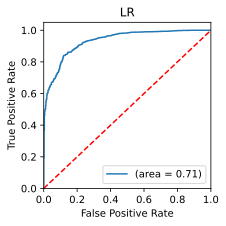

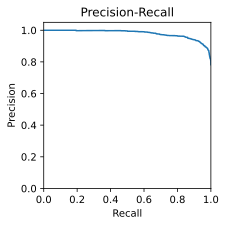

In [ ]:
start_LR = time.time()
LR = LogisticRegression(random_state=12345, solver='liblinear')
LR.fit(train_features, train_target)
mid_LR = time.time()
target_pred = LR.predict(test_features)
end_LR = time.time()
evaluate_model(LR,train_target, train_features, test_features, test_target)
curves(LR,'LR',test_target, test_features)

The performance of logistic regression is much better than previous model for accuracy, F1 metric, however ROC AUC is lower. We test for combined column:

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9003877523733119
Train Confusion Matrix:
[[ 846  716]
 [  29 5888]]
Train F1-Score:
0.9404999600670872

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8656776263031275
Test Confusion Matrix:
[[ 231  312]
 [  23 1928]]
Test F1-Score:
0.9200668098305894

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.43      0.58       543
           1       0.86      0.99      0.92      1951

    accuracy                           0.87      2494
   macro avg       0.89      0.71      0.75      2494
weighted avg       0.87      0.87      0.85      2494



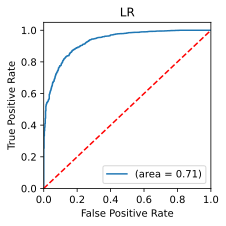

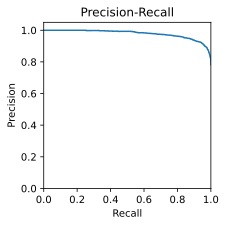

In [ ]:
start_LRC = time.time()
LRC = LogisticRegression(random_state=12345, solver='liblinear')
LRC.fit(train_features_comb, train_target_comb)
mid_LRC = time.time()
target_pred = LRC.predict(test_features_comb)
end_LRC = time.time()
evaluate_model(LRC,train_target_comb, train_features_comb, test_features_comb, test_target_comb)
curves(LRC,'LR',test_target_comb, test_features_comb)

There is no improvement, let's try Gridsearch. We would like to optimize hyperparameters to improve model performance:



In [ ]:
start_grid = time.time()
model = LogisticRegression(random_state = 12345)
params = [{'C':[1, 10],'penalty':['l1', 'l2'],'class_weight':[None, 'balanced'],'solver': ['liblinear', 'saga']}]
grid_search = GridSearchCV(model, params, scoring='f1',cv=5)
grid_search.fit(train_features, train_target)
end_grid = time.time()
best_params = grid_search.best_params_
print(best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9839550742077818
Train Confusion Matrix:
[[1458  104]
 [  16 5901]]
Train F1-Score:
0.9899345747357826

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8853247794707297
Test Confusion Matrix:
[[ 344  199]
 [  87 1864]]
Test F1-Score:
0.9287493771798704

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.71       543
           1       0.90      0.96      0.93      1951

    accuracy                           0.89      2494
   macro avg       0.85      0.79      0.82      2494
weighted avg       0.88      0.89      0.88      2494



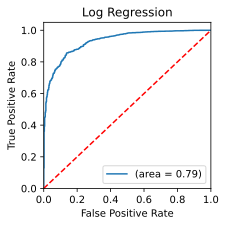

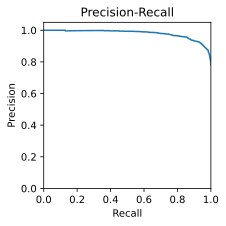

In [ ]:
start_LRG = time.time()
LRG=LogisticRegression(**best_params).fit(train_features, train_target)
mid_LRG = time.time()
target_pred = LRG.predict(test_features)
end_LRG = time.time()
evaluate_model(LRG,train_target, train_features, test_features, test_target)
curves(LRG,'Log Regression',test_target, test_features)

We see a difference between train and test accuracy & F1 metric. ROC AUC is at 0.79, which is better.

In [ ]:
eval_table["Accuracy"].values[1] = accuracy_score(test_target, LRG.predict(test_features))
eval_table["ROC AUC"].values[1] = roc_auc_score(test_target, LRG.predict(test_features))
eval_table["time_model"].values[1] = (mid_LRG-start_LRG)+ (end_grid-start_grid)
eval_table["time_predict"].values[1] = end_LRG-mid_LRG
eval_table["comment"].values[1] = "f1 at 0,92; difference between train and test exists"
eval_table

,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.885325,0.794462,75.264917,0.000875,"f1 at 0,92; difference between train and test ..."
2,DecisionTree,0.000000,0.000000,0.000000,0.000000,
3,Random_Forest,0.000000,0.000000,0.000000,0.000000,
4,SVM,0.000000,0.000000,0.000000,0.000000,
5,LGBM,0.000000,0.000000,0.000000,0.000000,


# c. Decision Trees

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 1.0
Train Confusion Matrix:
[[1562    0]
 [   0 5917]]
Train F1-Score:
1.0

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.7923015236567763
Test Confusion Matrix:
[[ 281  262]
 [ 256 1695]]
Test F1-Score:
0.8674513817809621

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       543
           1       0.87      0.87      0.87      1951

    accuracy                           0.79      2494
   macro avg       0.69      0.69      0.69      2494
weighted avg       0.79      0.79      0.79      2494



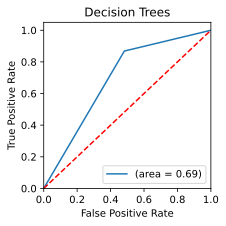

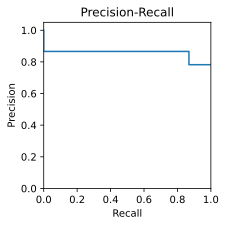

In [ ]:
start_DT = time.time()
DT = DecisionTreeClassifier(random_state=12345)
DT.fit(train_features, train_target)
mid_DT = time.time()
target_pred = DT.predict(test_features)
end_DT = time.time()
evaluate_model(DT,train_target, train_features, test_features, test_target)
curves(DT,'Decision Trees',test_target, test_features)

We see some overfitting, and need to tune our parameters, eg limit the depth:

In [ ]:
start_grid = time.time()
model = DecisionTreeClassifier(random_state=12345)
params = [{'max_depth':[None, 5,10,15,20],'min_samples_split':[5,10,20],'min_samples_leaf':[2,10],'class_weight':[None, 'balanced']}]
grid_search = GridSearchCV(model, params, scoring='f1',cv=5)
grid_search.fit(train_features, train_target)
end_grid = time.time()
best_params = grid_search.best_params_
print(best_params)

{'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 5}


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.8649552079154967
Train Confusion Matrix:
[[ 732  830]
 [ 180 5737]]
Train F1-Score:
0.9190964434476129

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8315958299919808
Test Confusion Matrix:
[[ 200  343]
 [  77 1874]]
Test F1-Score:
0.8992322456813818

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.37      0.49       543
           1       0.85      0.96      0.90      1951

    accuracy                           0.83      2494
   macro avg       0.78      0.66      0.69      2494
weighted avg       0.82      0.83      0.81      2494



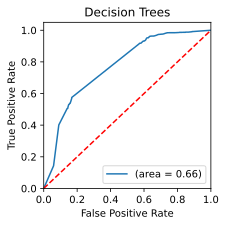

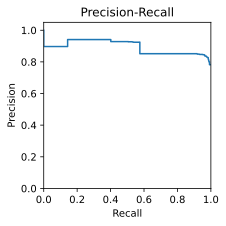

In [ ]:
start_DTG = time.time()
DTG=DecisionTreeClassifier(**best_params).fit(train_features, train_target)
mid_DTG = time.time()
target_pred = DTG.predict(test_features)
end_DTG = time.time()
evaluate_model(DTG,train_target, train_features, test_features, test_target)
curves(DTG,'Decision Trees',test_target, test_features)

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.8672282390693943
Train Confusion Matrix:
[[ 775  787]
 [ 206 5711]]
Train F1-Score:
0.9200161095449054

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8207698476343224
Test Confusion Matrix:
[[ 202  341]
 [ 106 1845]]
Test F1-Score:
0.8919506889050037

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.37      0.47       543
           1       0.84      0.95      0.89      1951

    accuracy                           0.82      2494
   macro avg       0.75      0.66      0.68      2494
weighted avg       0.80      0.82      0.80      2494



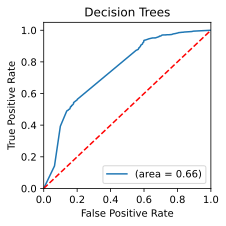

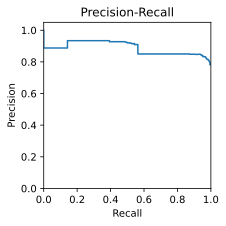

In [ ]:
start_DTGC = time.time()
DTGC=DecisionTreeClassifier(**best_params).fit(train_features_comb, train_target_comb)
mid_DTGC = time.time()
target_pred = DTGC.predict(test_features_comb)
end_DTGC = time.time()
evaluate_model(DTGC,train_target_comb, train_features_comb, test_features_comb, test_target_comb)
curves(DTGC,'Decision Trees',test_target_comb, test_features_comb)

In [ ]:
eval_table["Accuracy"].values[2] = accuracy_score(test_target, DTG.predict(test_features))
eval_table["ROC AUC"].values[2] = roc_auc_score(test_target, DTG.predict(test_features))
eval_table["time_model"].values[2] = (mid_DTG-start_DTG) + (end_grid-start_grid)
eval_table["time_predict"].values[2] = end_DTG-mid_DTG
eval_table["comment"].values[2] = "test f1 score at 0,89; less difference between train and test accuracy"
eval_table

,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.885325,0.794462,75.264917,0.000875,"f1 at 0,92; difference between train and test ..."
2,DecisionTree,0.831596,0.664429,213.003197,0.003445,"test f1 score at 0,89; less difference between..."
3,Random_Forest,0.000000,0.000000,0.000000,0.000000,
4,SVM,0.000000,0.000000,0.000000,0.000000,
5,LGBM,0.000000,0.000000,0.000000,0.000000,


# d. Random Forest

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 1.0
Train Confusion Matrix:
[[1562    0]
 [   0 5917]]
Train F1-Score:
1.0

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8311948676824379
Test Confusion Matrix:
[[ 132  411]
 [  10 1941]]
Test F1-Score:
0.9021612828259354

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.24      0.39       543
           1       0.83      0.99      0.90      1951

    accuracy                           0.83      2494
   macro avg       0.88      0.62      0.64      2494
weighted avg       0.85      0.83      0.79      2494



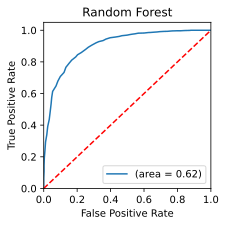

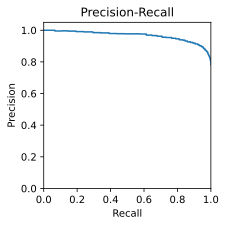

In [ ]:
start_RF = time.time()
RF = RandomForestClassifier(random_state=12345)
RF.fit(train_features, train_target)
mid_RF = time.time()
target_pred = RF.predict(test_features)
end_RF = time.time()
evaluate_model(RF,train_target, train_features, test_features, test_target)
curves(RF,'Random Forest',test_target, test_features)

Similar as for decision trees -> we need to tune parameters:

In [ ]:
start_grid = time.time()
model = RandomForestClassifier(random_state = 12345)
params = [{'n_estimators':[50,100],'max_depth':[None,5],'min_samples_split':[2,5],'min_samples_leaf':[1,5,10],'class_weight': [None, 'balanced']}]
grid_search = GridSearchCV(model, params, scoring='f1',cv=5)
grid_search.fit(train_features_comb, train_target_comb)
end_grid = time.time()
best_params = grid_search.best_params_
print(best_params)

{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9581494852252975
Train Confusion Matrix:
[[1452  110]
 [ 203 5714]]
Train F1-Score:
0.9733412826846095

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8813151563753007
Test Confusion Matrix:
[[ 363  180]
 [ 116 1835]]
Test F1-Score:
0.9253656076651537

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       543
           1       0.91      0.94      0.93      1951

    accuracy                           0.88      2494
   macro avg       0.83      0.80      0.82      2494
weighted avg       0.88      0.88      0.88      2494



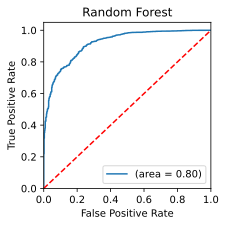

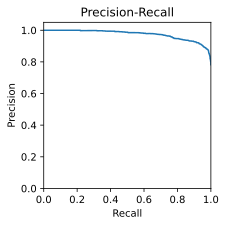

In [ ]:
start_RFG = time.time()
RFG = RandomForestClassifier(**best_params).fit(train_features, train_target)
mid_RFG = time.time()
target_pred = RFG.predict(test_features)
end_RFG = time.time()
evaluate_model(RFG,train_target, train_features, test_features, test_target)
curves(RFG,'Random Forest',test_target, test_features)

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9558764540713999
Train Confusion Matrix:
[[1456  106]
 [ 224 5693]]
Train F1-Score:
0.9718333902355754

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.871692060946271
Test Confusion Matrix:
[[ 351  192]
 [ 128 1823]]
Test F1-Score:
0.9193141704488149

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       543
           1       0.90      0.93      0.92      1951

    accuracy                           0.87      2494
   macro avg       0.82      0.79      0.80      2494
weighted avg       0.87      0.87      0.87      2494



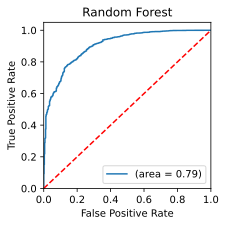

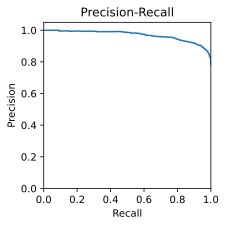

In [ ]:
start_RFGC = time.time()
RFGC=RandomForestClassifier(**best_params).fit(train_features_comb, train_target_comb)
mid_RFGC = time.time()
target_pred = RFGC.predict(test_features_comb)
end_RFGC = time.time()
evaluate_model(RFGC,train_target_comb, train_features_comb, test_features_comb, test_target_comb)
curves(RFGC,'Random Forest',test_target_comb, test_features_comb)

Result is better on just review column:

In [ ]:
eval_table["Accuracy"].values[3] = accuracy_score(test_target, RFG.predict(test_features))
eval_table["ROC AUC"].values[3] = roc_auc_score(test_target, RFG.predict(test_features))
eval_table["time_model"].values[3] = (mid_RFG-start_RFG) + (end_grid-start_grid)
eval_table["time_predict"].values[3] = end_RFG-mid_RFG
eval_table["comment"].values[3] = "test f1 score at 0,92"
eval_table

,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.885325,0.794462,75.264917,0.000875,"f1 at 0,92; difference between train and test ..."
2,DecisionTree,0.831596,0.664429,213.003197,0.003445,"test f1 score at 0,89; less difference between..."
3,Random_Forest,0.881315,0.804526,543.998319,0.088919,"test f1 score at 0,92"
4,SVM,0.000000,0.000000,0.000000,0.000000,
5,LGBM,0.000000,0.000000,0.000000,0.000000,


# e. Support Vector Classifier - SVC

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9868966439363551
Train Confusion Matrix:
[[1466   96]
 [   2 5915]]
Train F1-Score:
0.9917840375586855

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8668805132317562
Test Confusion Matrix:
[[ 237  306]
 [  26 1925]]
Test F1-Score:
0.9206121472979436

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.44      0.59       543
           1       0.86      0.99      0.92      1951

    accuracy                           0.87      2494
   macro avg       0.88      0.71      0.75      2494
weighted avg       0.87      0.87      0.85      2494



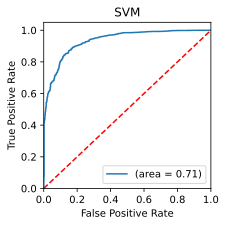

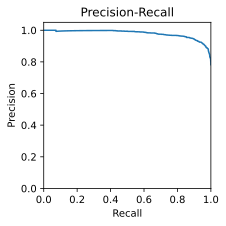

In [ ]:
start_SV = time.time()
SV = SVC(random_state=12345, probability=True)
SV.fit(train_features, train_target)
mid_SV = time.time()
target_pred = SV.predict(test_features)
end_SV = time.time()
evaluate_model(SV,train_target, train_features, test_features, test_target)
curves(SV,'SVM',test_target, test_features)

In [ ]:
start_grid = time.time()
model = SVC(random_state = 12345, probability=True)
params = [{ 'C': [0.1, 1],'class_weight': [None, 'balanced']}]
grid_search = GridSearchCV(model, params, scoring='f1',cv=3,n_jobs=-1)
grid_search.fit(train_features, train_target)
end_grid = time.time()
best_params = grid_search.best_params_
print(best_params)

{'C': 1, 'class_weight': 'balanced'}


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9958550608370103
Train Confusion Matrix:
[[1562    0]
 [  31 5886]]
Train F1-Score:
0.997373549097687

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8881315156375301
Test Confusion Matrix:
[[ 357  186]
 [  93 1858]]
Test F1-Score:
0.930162703379224

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       543
           1       0.91      0.95      0.93      1951

    accuracy                           0.89      2494
   macro avg       0.85      0.80      0.82      2494
weighted avg       0.88      0.89      0.88      2494



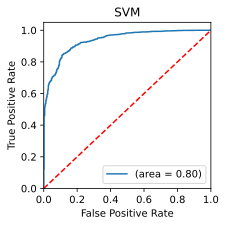

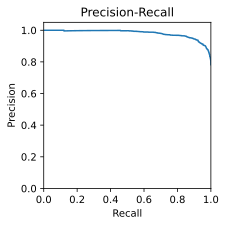

In [ ]:
start_SVG = time.time()
SVG=SVC(**best_params, probability=True).fit(train_features, train_target)
mid_SVG = time.time()
target_pred = SVG.predict(test_features)
end_SVG = time.time()
evaluate_model(SVG,train_target, train_features, test_features, test_target)
curves(SVG,'SVM',test_target, test_features)

In [ ]:
eval_table["Accuracy"].values[4] = accuracy_score(test_target, SVG.predict(test_features))
eval_table["ROC AUC"].values[4] = roc_auc_score(test_target, SVG.predict(test_features))
eval_table["time_model"].values[4] = (mid_SVG-start_SVG) + (end_grid-start_grid)
eval_table["time_predict"].values[4] = end_SVG-mid_SVG
eval_table["comment"].values[4] = "test f1 at 0,93; Train accuracy is very high"
eval_table

,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.885325,0.794462,75.264917,0.000875,"f1 at 0,92; difference between train and test ..."
2,DecisionTree,0.831596,0.664429,213.003197,0.003445,"test f1 score at 0,89; less difference between..."
3,Random_Forest,0.881315,0.804526,543.998319,0.088919,"test f1 score at 0,92"
4,SVM,0.888132,0.804895,716.061873,7.922070,"test f1 at 0,93; Train accuracy is very high"
5,LGBM,0.000000,0.000000,0.000000,0.000000,


# f. Light Gradient Boosting Machine - LGBM

[LightGBM] [Info] Number of positive: 5917, number of negative: 1562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73325
[LightGBM] [Info] Number of data points in the train set: 7479, number of used features: 1820
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.791149 -> initscore=1.331863
[LightGBM] [Info] Start training from score 1.331863


**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

Train Accuracy : 0.9762000267415429
Train Confusion Matrix:
[[1403  159]
 [  19 5898]]
Train F1-Score:
0.9851344579923166

--------------------------------------------------



**Test Evaluation**

Test Accuracy : 0.8748997594226142
Test Confusion Matrix:
[[ 309  234]
 [  78 1873]]
Test F1-Score:
0.9231148348940366

--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.66       543
           1       0.89      0.96      0.92      1951

    accuracy                           0.87      2494
   macro avg       0.84      0.76      0.79      2494
weighted avg       0.87      0.87      0.87      2494



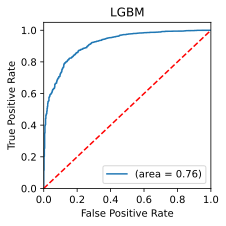

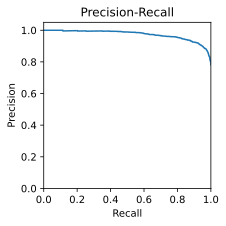

In [ ]:
start_LGBM = time.time()
LGBM = LGBMClassifier(random_state=12345)
LGBM.fit(train_features, train_target)
mid_LGBM = time.time()
target_pred = LGBM.predict(test_features)
end_LGBM = time.time()
evaluate_model(LGBM,train_target, train_features, test_features, test_target)
curves(LGBM,'LGBM',test_target, test_features)

In [ ]:
#num_negatives = np.sum(train_target == 0)
#num_positives = np.sum(train_target == 1)
#ratio = num_negatives / num_positives
#print(ratio)

In [ ]:
start_grid = time.time()
model = LGBMClassifier(random_state=12345)
params = [{'is_unbalance': [True, False],'lambda_l1': [0.0, 0.1],'lambda_l2': [0.0, 0.1]}]
grid_search = GridSearchCV(model, params, scoring='f1',cv=3, n_jobs=-1)
end_grid = time.time()
grid_search.fit(train_features, train_target)
best_params = grid_search.best_params_
print(best_params)

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 5917, number of negative: 1562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73325
[LightGBM] [Info] Number of data points in the train set: 7479, number of used features: 1820
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.791149 -> initscore=1.331863
[LightGBM] [Info] Start training from score 1.331863
{'is_unbalance': False, 'lambd

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 5917, number of negative: 1562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73325
[LightGBM] [Info] Number of data points in the train set: 7479, number of used features: 1820
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.791149 -> initscore=1.331863
[LightGBM] [Info] Start training from score 1.331863
[LightGBM] [Warning] lambda_l2

**Model Evaluation**

--------------------------------------------------



**Train Evaluation**

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
Train Accuracy : 0.9752640727369969
Train Confusion Matrix:
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[[1397  165]
 [  20 5897]]
Train F1-Score:
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
0.9845563068703563

--------------------------------------------------



**Test Evaluation**

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
Test Accuracy : 0.8781074578989575
Test Confusion Matrix:
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[[ 310  233]
 [  71 1880]]
Test F1-Score:
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
0.9251968503937008

--------------------------------------------------

Classification Report:
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Curren

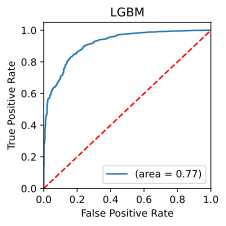

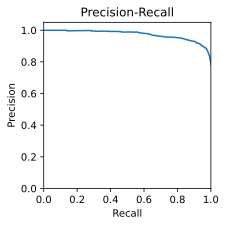

In [ ]:
start_LGBMG = time.time()
LGBMG=LGBMClassifier(**best_params).fit(train_features, train_target)
mid_LGBMG = time.time()
target_pred = LGBMG.predict(test_features)
end_LGBMG = time.time()
evaluate_model(LGBMG,train_target, train_features, test_features, test_target)
curves(LGBMG,'LGBM',test_target, test_features)

In [ ]:
eval_table["Accuracy"].values[5] = accuracy_score(test_target, LGBMG.predict(test_features))
eval_table["ROC AUC"].values[5] = roc_auc_score(test_target, LGBMG.predict(test_features))
eval_table["time_model"].values[5] = (mid_LGBMG-start_LGBMG) + (end_grid-start_grid)
eval_table["time_predict"].values[5] = (end_LGBMG-mid_LGBMG)
eval_table["comment"].values[5] = " f1 score is at 0.92"
eval_table

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.885325,0.794462,75.264917,0.000875,"f1 at 0,92; difference between train and test ..."
2,DecisionTree,0.831596,0.664429,213.003197,0.003445,"test f1 score at 0,89; less difference between..."
3,Random_Forest,0.881315,0.804526,543.998319,0.088919,"test f1 score at 0,92"
4,SVM,0.888132,0.804895,716.061873,7.922070,"test f1 at 0,93; Train accuracy is very high"
5,LGBM,0.878107,0.767255,5.829247,0.026885,f1 score is at 0.92


<a name="3"></a>
# 3. Summary

Our aim was to explore and analyse the sentiment of the reviews. We performed some preprocessing of the data and analyzed 6 models. We received the following results:


In [ ]:
eval_table

,models,Accuracy,ROC AUC,time_model,time_predict,comment
0,Naive_Bayes,0.813953,0.767452,0.006138,0.001173,f1 score at 0.88; difference in accuracy betwe...
1,Log_Regression,0.885325,0.794462,75.264917,0.000875,"f1 at 0,92; difference between train and test ..."
2,DecisionTree,0.831596,0.664429,213.003197,0.003445,"test f1 score at 0,89; less difference between..."
3,Random_Forest,0.881315,0.804526,543.998319,0.088919,"test f1 score at 0,92"
4,SVM,0.888132,0.804895,716.061873,7.922070,"test f1 at 0,93; Train accuracy is very high"
5,LGBM,0.878107,0.767255,5.829247,0.026885,f1 score is at 0.92


Based on the results Naive Bayes and Decision Trees show not that good performance. We could consider logistic regression, SVC, RD, LGBM. More complex models require more time for training and prediction.

Random Forest seems to provide good results and less difference between training and test accuracy.

<a name="4"></a>
# 4. Spark Exercise

In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import explode, split, col

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Reviews_exploration") \
    .getOrCreate()

In [ ]:
df = spark.read.option("delimiter",";").csv(file_path,header=True)

In [ ]:
df.show()

+--------------------+--------------------+---------+
|                name|              review|sentiment|
+--------------------+--------------------+---------+
|Annas Dream Full ...|Very soft and com...| positive|
|Stop Pacifier Suc...|This is a product...| positive|
|Stop Pacifier Suc...|All of my kids ha...| positive|
|Stop Pacifier Suc...|When the Binky Fa...| positive|
|A Tale of Baby's ...|Lovely book, it's...| positive|
|Baby Tracker&reg,...|Perfect for new p...| positive|
|Baby Tracker&reg,...|A friend of mine ...| positive|
|Baby Tracker&reg,...|This has been an ...| positive|
|Baby Tracker&reg,...|I love this journ...| positive|
|Baby Tracker&reg,...|This book is perf...| positive|
|Baby Tracker&reg,...|I originally just...| positive|
|Nature's Lullabie...|Space for monthly...| positive|
|Nature's Lullabie...|I bought this cal...| positive|
|Nature's Lullabie...|I love this littl...| positive|
|Nature's Lullabie...|This was the only...| positive|
|Nature's Lullabie...|I comp

In [ ]:
# Split the columns into words
words = (df.withColumn('word', explode(split(col('review'), " "))).alias("word"))
words.show(5)
# Generate running word count
wordCounts = words.groupBy("word").count().sort('count', ascending=False)
wordCounts.show(20)

+--------------------+--------------------+---------+-----------+
|                name|              review|sentiment|       word|
+--------------------+--------------------+---------+-----------+
|Annas Dream Full ...|Very soft and com...| positive|       Very|
|Annas Dream Full ...|Very soft and com...| positive|       soft|
|Annas Dream Full ...|Very soft and com...| positive|        and|
|Annas Dream Full ...|Very soft and com...| positive|comfortable|
|Annas Dream Full ...|Very soft and com...| positive|        and|
+--------------------+--------------------+---------+-----------+
only showing top 5 rows

+----+-----+
|word|count|
+----+-----+
| the|43003|
| and|27940|
|  to|26988|
|   I|26303|
|    |23301|
|   a|20392|
|  it|18521|
|  is|14451|
| for|12207|
|  of|11467|
|this|10544|
|  in|10370|
|  my| 8995|
|that| 8944|
|with| 7926|
|have| 7886|
| was| 7621|
|  on| 7072|
| you| 5511|
| but| 5389|
+----+-----+
only showing top 20 rows



We want to calculate the number of positive reviews per product:

In [ ]:
#option 1
#we register the DataFrame as a temporary view to run SQL
df.createOrReplaceTempView("sentiment")
sql= spark.sql("SELECT name, count(sentiment) FROM sentiment WHERE sentiment='positive' GROUP BY name ORDER BY count(sentiment) DESC")
sql.show()

+--------------------+----------------+
|                name|count(sentiment)|
+--------------------+----------------+
|Leachco Snoogle T...|             338|
|Baby Trend Diaper...|             248|
|BABYBJORN Potty C...|             209|
|The First Year's ...|             195|
|PRIMO EuroBath, P...|             162|
|Munchkin Mozart M...|             156|
|The First Years H...|             153|
|BABYBJORN Toilet ...|             133|
|Graco TotBloc Pac...|             128|
|HALO SleepSack Mi...|             116|
|Leachco Safer Bat...|             111|
|HALO SleepSack 10...|             104|
|Prince Lionheart ...|             100|
|Philips Avent 3 P...|              96|
|The First Years B...|              83|
|Diaper Dekor Plus...|              81|
|Avent Isis Manual...|              79|
|Regalo Easy Diner...|              79|
|Prince Lionheart ...|              77|
|BABYBJORN Safe St...|              71|
+--------------------+----------------+
only showing top 20 rows



In [ ]:
#option 2
pr = df.filter(col('sentiment')=='positive')
pr_count = pr.groupBy('name').count().orderBy('count', ascending=False)
pr_count.show()

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Leachco Snoogle T...|  338|
|Baby Trend Diaper...|  248|
|BABYBJORN Potty C...|  209|
|The First Year's ...|  195|
|PRIMO EuroBath, P...|  162|
|Munchkin Mozart M...|  156|
|The First Years H...|  153|
|BABYBJORN Toilet ...|  133|
|Graco TotBloc Pac...|  128|
|HALO SleepSack Mi...|  116|
|Leachco Safer Bat...|  111|
|HALO SleepSack 10...|  104|
|Prince Lionheart ...|  100|
|Philips Avent 3 P...|   96|
|The First Years B...|   83|
|Diaper Dekor Plus...|   81|
|Avent Isis Manual...|   79|
|Regalo Easy Diner...|   79|
|Prince Lionheart ...|   77|
|BABYBJORN Safe St...|   71|
+--------------------+-----+
only showing top 20 rows



Now we would like to calculate the number of positive and negative reviews per product:

In [ ]:
#option1
sql2 = spark.sql("SELECT name, sentiment, count(sentiment) FROM sentiment GROUP BY name, sentiment ORDER BY name")
sql2.show()

+--------------------+---------+----------------+
|                name|sentiment|count(sentiment)|
+--------------------+---------+----------------+
|                NULL| positive|               1|
|                NULL| negative|               2|
|100% Cotton Terry...| negative|               2|
|100% Cotton Terry...| positive|               4|
|2-in-1 Car Seat C...| positive|               6|
|2-in-1 Car Seat C...| negative|               5|
|3 - in - 1 Feedin...| positive|               2|
|3 Easy Grasp Soft...| positive|               1|
|3-in-1 Fold and G...| positive|               2|
|4 Pack Multi Use ...| negative|               1|
|4 Piece Kimono Gi...| positive|               1|
|5 Pack Receiving ...| positive|               2|
|5 Pack Receiving ...| negative|               1|
|5 Pack Receiving ...| positive|               1|
|5 Pack Receiving ...| negative|               1|
|6 Piece Bedding S...| positive|               7|
|8&quot, Tinkle Cr...| negative|               1|


In [ ]:
#option2
r_count = df.groupBy('name', 'sentiment').count().orderBy('name', 'sentiment')
r_count.show(10)

+--------------------+---------+-----+
|                name|sentiment|count|
+--------------------+---------+-----+
|                NULL| negative|    2|
|                NULL| positive|    1|
|100% Cotton Terry...| negative|    2|
|100% Cotton Terry...| positive|    4|
|2-in-1 Car Seat C...| negative|    5|
|2-in-1 Car Seat C...| positive|    6|
|3 - in - 1 Feedin...| positive|    2|
|3 Easy Grasp Soft...| positive|    1|
|3-in-1 Fold and G...| positive|    2|
|4 Pack Multi Use ...| negative|    1|
+--------------------+---------+-----+
only showing top 10 rows



We want to check if there any records with empty reviews:

In [ ]:
#option 1
sql3 = spark.sql("SELECT name, review, sentiment FROM sentiment WHERE review is NULL")
sql3.show()

+--------------------+------+---------+
|                name|review|sentiment|
+--------------------+------+---------+
|SoftPlay Twinkle ...|  NULL| positive|
|Our Baby Girl Mem...|  NULL| positive|
|Summer Infant, Ul...|  NULL| positive|
|Safety 1st Deluxe...|  NULL| negative|
|Northstate Supery...|  NULL| positive|
|Munchkin Mozart M...|  NULL| positive|
|Graco TotBloc Pac...|  NULL| positive|
|Graco TotBloc Pac...|  NULL| positive|
|Prince Lionheart ...|  NULL| negative|
|BABYBJORN Toilet ...|  NULL| positive|
|BABYBJORN Potty C...|  NULL| positive|
|DEX Products Preg...|  NULL| positive|
|DEX Products Preg...|  NULL| negative|
|Playtex 3 Pack BP...|  NULL| positive|
|The First Years B...|  NULL| negative|
|The First Years S...|  NULL| positive|
|  Sliding Door Locks|  NULL| negative|
|Graco - Duo Strol...|  NULL| positive|
|Prince Lionheart ...|  NULL| positive|
|Dr. Brown's Natur...|  NULL| negative|
+--------------------+------+---------+
only showing top 20 rows



In [ ]:
#option2
reviews_emt = df.filter(col('review').isNull())
reviews_emt.show()
reviews_emt = reviews_emt.count()
print({reviews_emt})

+--------------------+------+---------+
|                name|review|sentiment|
+--------------------+------+---------+
|SoftPlay Twinkle ...|  NULL| positive|
|Our Baby Girl Mem...|  NULL| positive|
|Summer Infant, Ul...|  NULL| positive|
|Safety 1st Deluxe...|  NULL| negative|
|Northstate Supery...|  NULL| positive|
|Munchkin Mozart M...|  NULL| positive|
|Graco TotBloc Pac...|  NULL| positive|
|Graco TotBloc Pac...|  NULL| positive|
|Prince Lionheart ...|  NULL| negative|
|BABYBJORN Toilet ...|  NULL| positive|
|BABYBJORN Potty C...|  NULL| positive|
|DEX Products Preg...|  NULL| positive|
|DEX Products Preg...|  NULL| negative|
|Playtex 3 Pack BP...|  NULL| positive|
|The First Years B...|  NULL| negative|
|The First Years S...|  NULL| positive|
|  Sliding Door Locks|  NULL| negative|
|Graco - Duo Strol...|  NULL| positive|
|Prince Lionheart ...|  NULL| positive|
|Dr. Brown's Natur...|  NULL| negative|
+--------------------+------+---------+
only showing top 20 rows

{23}


In [ ]:
new_rdd = df.rdd
filtered_rdd = new_rdd.filter(lambda x: x[1] is None)

In [ ]:
filtered_rdd.collect()

[Row(name='SoftPlay Twinkle Twinkle Elmo A Bedtime Book', review=None, sentiment='positive'),
 Row(name='Our Baby Girl Memory Book', review=None, sentiment='positive'),
 Row(name='Summer Infant, Ultimate Training Pad - Twin Mattress, 38&quot, x 28&quot,', review=None, sentiment='positive'),
 Row(name='Safety 1st Deluxe 4-in-1 Bath Station', review=None, sentiment='negative'),
 Row(name='Northstate Superyard Playgate Light Gray', review=None, sentiment='positive'),
 Row(name='Munchkin Mozart Magic Cube', review=None, sentiment='positive'),
 Row(name="Graco TotBloc Pack 'N Play with Carry Bag, Bugs Quilt", review=None, sentiment='positive'),
 Row(name="Graco TotBloc Pack 'N Play with Carry Bag, Bugs Quilt", review=None, sentiment='positive'),
 Row(name='Prince Lionheart Table Edge Guard with 4 Corners, Grey', review=None, sentiment='negative'),
 Row(name='BABYBJORN Toilet Trainer - White/Red', review=None, sentiment='positive'),
 Row(name='BABYBJORN Potty Chair - Red', review=None, senti

In [ ]:
spark.stop()